In [ ]:
#default_exp data
from nbdev.showdoc import show_doc

In [ ]:
#export
import os, zarr, cv2, imageio, shutil, numpy as np
from joblib import Parallel, delayed

from scipy import ndimage
from scipy.interpolate import Rbf
from scipy.interpolate import interp1d

from matplotlib.patches import Rectangle
from skimage.measure import label
from skimage.color import label2rgb

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from fastai.vision.all import *
from fastcore.all import *
from deepflash2.transforms import random_center, WeightTransform, preprocess_mask, create_pdf

import gc
gc.enable()

# Data

> This module defines tools for image data preprocessing and real-time data augmentation that is used to train a model.

__Original Paper:__ Falk, Thorsten, et al. "U-Net: deep learning for cell counting, detection, and morphometry." Nature methods 16.1 (2019): 67-70.

The code for data augmentation and mask weight generation was provided by the authors and adapted for this package.

## Plot images and masks

In [ ]:
#export
def show(*obj, file_name=None, overlay=False, pred=False,
         show_bbox=True, figsize=(10,10), cmap='binary_r', **kwargs):
    "Show image, mask, and weight (optional)"
    if len(obj)==3:
        img,msk,weight = obj
    elif len(obj)==2:
        img,msk = obj
        weight = None
    elif len(obj)==1:
        img = obj[0]
        msk, weight = None, None
        
    else:
        raise ValueError(f'Function not defined for {len(obj)} arguments.')
    
    # Image preprocessing
    img = np.array(img)
    # Swap axis to channels last
    if img.shape[0]<20: img=np.moveaxis(img,0,-1)
    # One channel images
    if img.ndim == 3 and img.shape[-1] == 1: 
        img=img[...,0]

    # Mask preprocessing
    if msk is not None:
        msk = np.array(msk)
        # Remove background class from masks
        if msk.shape[0]==2: msk=msk[1,...]
        # Create bbox

        pad = (np.array(img.shape[:2])-np.array(msk.shape))//2
        bbox = Rectangle((pad[0]-1,pad[1]-1),img.shape[0]-2*pad[0]+1,img.shape[0]-2*pad[0]+1,
                 edgecolor='r',linewidth=1,facecolor='none')

        # Padding mask and weights
        msk = np.pad(msk, pad, 'constant', constant_values=(0))

        if cmap is None:
            cmap = 'binary_r' if msk.max()==1 else cmap
    
    # Weights preprocessing
    if weight is not None:
        weight = np.array(weight)
        weight = np.pad(weight, pad, 'constant', constant_values=(0))

    ncol=1 if msk is None else 2
    ncol=ncol if weight is None else ncol+1
    fig, ax = plt.subplots(1,ncol,figsize=figsize)
    img_ax = ax[0] if ncol>1 else ax
    
    # Plot img
    img_ax.imshow(img, cmap=cmap)
    if file_name is not None:
        img_ax.set_title('Image {}'.format(file_name))
    else:
        img_ax.set_title('Image')
    img_ax.set_axis_off()

    # Plot img and mask
    if msk is not None:
        if overlay:
            label_image = label(msk)
            img_l2o = label2rgb(label_image, image=img, bg_label=0, alpha=.8, image_alpha=1)
            ax[1].set_title('Image + Mask (#ROIs: {})'.format(label_image.max()))
            ax[1].imshow(img_l2o)
        else:
            ax[1].imshow(msk, cmap=cmap)
            ax[1].set_title('Mask')
        if show_bbox: ax[1].add_patch(copy(bbox))

        ax[1].set_axis_off()

    # Plot weights
    if weight is not None:
        max_w = weight.max()
        vmax_w = max(1, max_w)
        ax[2].imshow(weight, vmax=vmax_w, cmap=cmap)
        if pred:
            ax[2].set_title('Prediction')
        else:
            ax[2].set_title('Weights (max value: {:.{p}f})'.format(max_w, p=1))
        if show_bbox: ax[2].add_patch(copy(bbox))
        ax[2].set_axis_off()

    #ax.set_axis_off()
    plt.tight_layout()
    plt.show()

The show methods in fastai all rely on some types being able to show themselves. We create a new type with a show method.

#### Typedispatch

Custom `show_batch` and `show_results` for  `DataLoader`

In [ ]:
#export
@typedispatch
def show_batch(x:TensorImage, y:tuple, samples, max_n=6, figsize=None, **kwargs):
    "Show one batch (image, mask, and weights) from a `DataLoader`"
    max_n = np.min((max_n, len(x)))
    if figsize is None: figsize = (12, max_n * 5)
    for i in range(max_n): show(x[i], y[0][i], y[1][i], figsize=figsize, **kwargs)

In [ ]:
#export
@typedispatch
def show_results(x:TensorImage, y:tuple, samples, outs, max_n=4, figsize=None, **kwargs):
    "Show image, mask, and weights from `max_n` items"
    max_n = np.min((max_n, len(x)))
    if figsize is None: figsize = (12, max_n * 5)
    for i in range(max_n): show(x[i], y[0][i], outs[i][0], pred=True, figsize=figsize, **kwargs)

__Example image and mask__

We will use an example image and mask to guide through the documentation.

In [ ]:
#hide
# Generate an initial random image and mask with two circles
x, y = np.indices((540, 540))
x1, y1, x2, y2 = 180, 180, 41*7, 52*7
r1, r2 = 10*7.20, 20*7
#x1, y1, x2, y2 = 180, 180, 44*7, 52*7
#r1, r2 = 10*7, 20*7
mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
mask = np.logical_or(mask_circle1, mask_circle2).astype(int)
image = np.random.rand(*mask.shape)+mask*2.
#image[mask==1] = np.abs(image[mask==1])+1
path=Path('sample_data')
(path/'images').mkdir(parents=True, exist_ok=True)
imageio.imsave(path/'images'/'01.png', image)
(path/'labels').mkdir(parents=True, exist_ok=True)
imageio.imsave(path/'labels'/'01_mask.png', (mask*255).astype('uint8'))

Lossy conversion from float64 to uint8. Range [1.5565152355900835e-07, 2.9999985391105453]. Convert image to uint8 prior to saving to suppress this warning.


Plot example image and mask

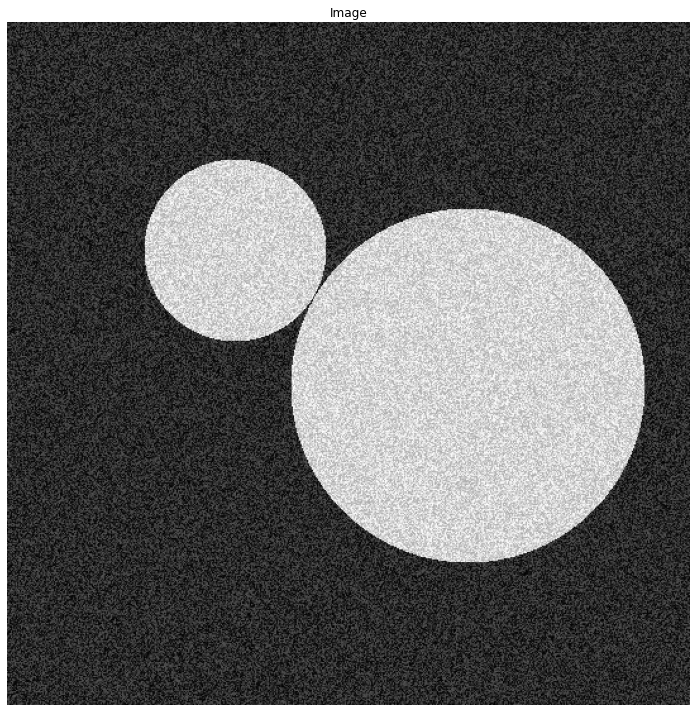

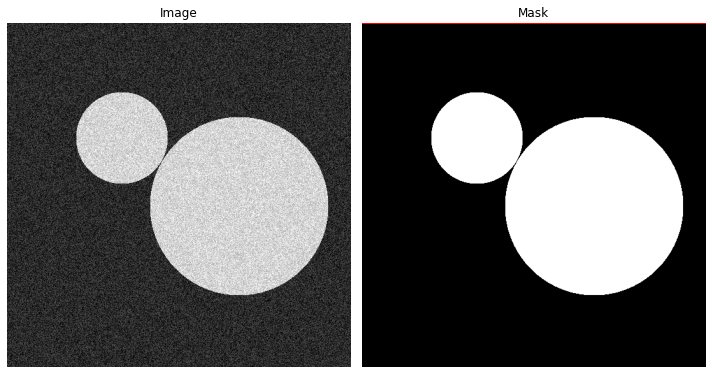

In [ ]:
image = imageio.imread(path/'images'/'01.png')
mask = imageio.imread(path/'labels'/'01_mask.png')#//255
show(image)
show(image, mask)

## Data augmentation

Deformation field class to ensure that all augmentations are performed equally on images, masks, and weights. Implemented augmentations are
- rotation
- mirroring
- random deformation

In [ ]:
#export
class DeformationField:
    "Creates a deformation field for data augmentation"
    def __init__(self, shape=(540, 540), scale=1):
        self.shape, self.scale = shape, scale
        #grid_range = [np.arange(d*self.scale, step=scale) - (d*self.scale) / 2 for d in shape]
        #grid_range = [np.linspace(-(d*self.scale)/2, (d*self.scale)/2, d) for d in shape]
        # Same behavoiur as np.arange
        grid_range = [np.linspace(-(d*self.scale)/2, ((d*self.scale)/2)-1, d) for d in shape] 
        self.deformationField = np.meshgrid(*grid_range)[::-1]
        self.orders = [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC]

    def rotate(self, theta=0, phi=0, psi=0):
        "Rotate deformation field"
        if len(self.shape) == 2:
            self.deformationField = [
                self.deformationField[0] * np.cos(theta)
                + self.deformationField[1] * np.sin(theta),
                -self.deformationField[0] * np.sin(theta)
                + self.deformationField[1] * np.cos(theta),
            ]
        else:
            self.deformationField = [
                self.deformationField[0],
                self.deformationField[1] * np.cos(theta)
                + self.deformationField[2] * np.sin(theta),
                -self.deformationField[1] * np.sin(theta)
                + self.deformationField[2] * np.cos(theta),
            ]
            self.deformationField = [
                self.deformationField[0] * np.cos(phi)
                + self.deformationField[2] * np.sin(phi),
                self.deformationField[1]
                - self.deformationField[0] * np.sin(phi)
                + self.deformationField[2] * np.cos(phi),
            ]
            self.deformationField = [
                self.deformationField[0],
                self.deformationField[1] * np.cos(psi)
                + self.deformationField[2] * np.sin(psi),
                -self.deformationField[1] * np.sin(psi)
                + self.deformationField[2] * np.cos(psi),
            ]

    def mirror(self, dims):
        "Mirror deformation fild at dims"
        for d in range(len(self.shape)):
            if dims[d]:
                self.deformationField[d] = -self.deformationField[d]

    def addRandomDeformation(self, grid=(150, 150), sigma=(10, 10)):
        "Add random deformation to the deformation field"
        seedGrid = np.meshgrid(
            *[np.arange(-g / 2, s + g / 2, g) for (g, s) in zip(grid, self.shape)]
        )
        seed = [np.random.normal(0, s, g.shape) for (g, s) in zip(seedGrid, sigma)]
        defFcn = [Rbf(*seedGrid, s, function="cubic") for s in seed]
        targetGrid = np.meshgrid(*map(np.arange, self.shape))
        deformation = [f(*targetGrid) for f in defFcn]
        self.deformationField = [
            f + df for (f, df) in zip(self.deformationField, deformation)
        ]

    def get(self, offset=(0, 0), pad=(0, 0)):
        "Get relevant slice from deformation field"
        sliceDef = tuple(slice(int(p / 2), int(-p / 2)) if p > 0 else None for p in pad)
        deform = [d[sliceDef] for d in self.deformationField]
        return [d + offs for (d, offs) in zip(deform, offset)]

    def apply_slow(self, data, offset=(0, 0), pad=(0, 0), order=1):
        "Apply deformation field to image using interpolation"
        outshape = tuple(int(s - p) for (s, p) in zip(self.shape, pad))
        coords = [d.flatten() for d in self.get(offset, pad)]
        if len(data.shape) == len(self.shape) + 1:
            tile = np.empty((data.shape[-1], *outshape))
            for c in range(data.shape[-1]):
                tile[c,...] = ndimage.interpolation.map_coordinates(data[..., c], coords, order=order, mode="reflect").reshape(outshape)
        else:
            tile = ndimage.interpolation.map_coordinates(data, coords, order=order, mode="reflect").reshape(outshape)
        return tile.astype(data.dtype)
    
    def apply(self, data, offset=(0, 0), pad=(0, 0), order=1):
        "Apply deformation field to image using interpolation"
        outshape = tuple(int(s - p) for (s, p) in zip(self.shape, pad))
        coords = [np.squeeze(d).astype('float32').reshape(*outshape) for d in self.get(offset, pad)]
        # Get slices to avoid loading all data (.zarr files)
        sl = []
        for i in range(len(coords)):
            cmin, cmax = int(coords[i].min()), int(coords[i].max())
            dmax = data.shape[i]
            if cmin<0: 
                cmax = max(-cmin, cmax)
                cmin = 0 
            elif cmax>dmax:
                cmin = min(cmin, 2*dmax-cmax)
                cmax = dmax
                coords[i] -= cmin
            else: coords[i] -= cmin
            sl.append(slice(cmin, cmax))    
        if len(data.shape) == len(self.shape) + 1:
            tile = np.empty((data.shape[-1], *outshape))
            for c in range(data.shape[-1]):
                tile[c,...] = cv2.remap(data[sl[0],sl[1], c], coords[1],coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
        else:
            tile = cv2.remap(data[sl[0], sl[1]], coords[1], coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
        return tile

Original Image

Using real-time weight calculation.


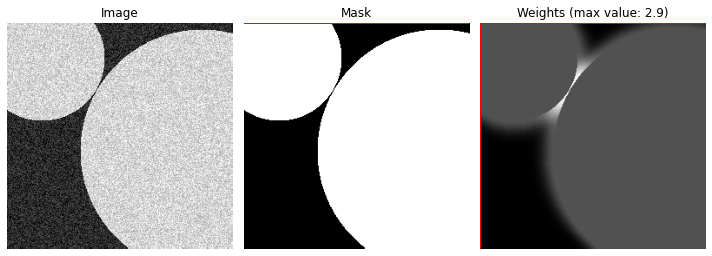

In [ ]:
inst_labels, _ = ndimage.measurements.label(mask)
inp = torch.Tensor(inst_labels)
wt = WeightTransform(channels=inp.size(-1))
weights = wt(inp.view(1, *inp.shape))[0].numpy()
tst = DeformationField(shape=(260, 260))
show(tst.apply(image, offset=(270,270)), 
     tst.apply(mask, offset=(270,270)), 
     tst.apply(weights, offset=(270,270)))

Add mirroring

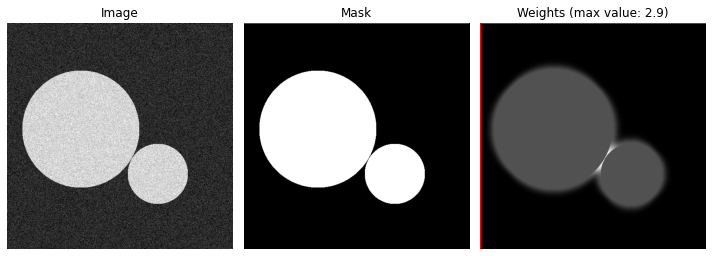

In [ ]:
tst = DeformationField()
tst.mirror((1,1))
show(tst.apply(image, offset=(270,270)), 
     tst.apply(mask, offset=(270,270)), 
     tst.apply(weights, offset=(270,270)))

Add random deformation

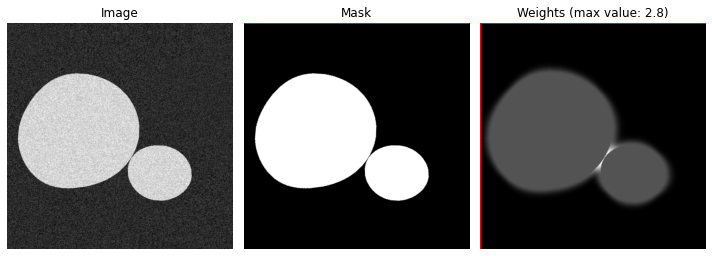

In [ ]:
tst.addRandomDeformation()
show(tst.apply(image, offset=(270,270)), 
     tst.apply(mask, offset=(270,270)), 
     tst.apply(weights, offset=(270,270)))

Add rotation

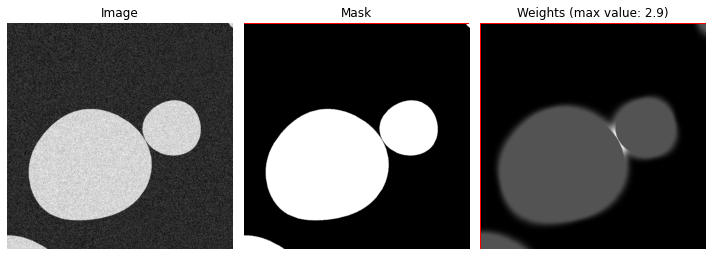

In [ ]:
tst.rotate(1,1,1)
show(tst.apply(image, offset=(270,270)), 
     tst.apply(mask, offset=(270,270)), 
     tst.apply(weights, offset=(270,270)))

## Datasets

Pytorch map-style [datasets](https://pytorch.org/docs/stable/data.html) for training and validation.

### Helper functions

In [ ]:
#export
def _read_img(path, divide=None, **kwargs):
    "Read image and normalize to 0-1 range"
    if path.suffix == '.zarr':
        img = zarr.convenience.open(path.as_posix()) 
        if len(img.shape)==4: # assuming shape (z_dim, n_channel, y_dim, x_dim)
            img = np.max(img, axis=0) # max z projection
            img = np.moveaxis(img, 0, -1)
    else:
        img = imageio.imread(path, **kwargs)
        if divide is None and img.max()>0:
            img = img/np.iinfo(img.dtype).max
        if divide is not None:
            img = img/divide
        #assert img.max()<=1. and img.max()>.04, f'Check image loading, dividing by {divide}, max value is {img.max()}'
        assert img.max()<=1., f'Check image loading, dividing by {divide}'
    if img.ndim == 2:
        img = np.expand_dims(img, axis=2)
    return img

In [ ]:
#export
def _read_msk(path, n_classes=2, instance_labels=False, **kwargs):
    "Read image and check classes"
    if path.suffix == '.zarr':
        msk = zarr.convenience.open(path.as_posix()) 
    else: 
        msk = imageio.imread(path, **kwargs)
    if not instance_labels:
        if np.max(msk)>n_classes:
            msk = msk//np.iinfo(msk.dtype).max
        # Remove channels if no extra information given
        if len(msk.shape)==3:
            if np.array_equal(msk[...,0], msk[...,1]):
                msk = msk[...,0]
        # Mask check
        assert len(np.unique(msk))<=n_classes, 'Check n_classes and provided mask'
    return msk

### Base Class

In [ ]:
#export
class BaseDataset(Dataset):
    def __init__(self, files, label_fn=None, instance_labels = False, n_classes=2, divide=None, ignore={},remove_overlap=True,
                 tile_shape=(540,540), padding=(184,184),preproc_dir=None, fbr=.1, n_jobs=-1, verbose=1, scale=1, loss_weights=True, **kwargs):
        store_attr('files, label_fn, instance_labels, divide, n_classes, ignore, tile_shape, remove_overlap, padding, fbr, scale, loss_weights')
        self.c = n_classes
        if label_fn is not None:             
            if not preproc_dir: self.preproc_dir = Path(label_fn(files[0])).parent/'.cache'
            else: self.preproc_dir = Path(preproc_dir)
            self.labels = zarr.group((self.preproc_dir/'labels').as_posix())
            self.pdfs = zarr.group((self.preproc_dir/'pdfs').as_posix())
            self._preproc(n_jobs, verbose)
                
    def read_img(self, *args, **kwargs):
        return _read_img(*args, **kwargs)
        
    def read_mask(self, *args, **kwargs):
        return _read_msk(*args, **kwargs)
    
    def _name_fn(self, g):
        "Name of preprocessed and compressed data."
        return f'{g}_{self.fbr}'    
    
    def _preproc_file(self, file):
        "Preprocesses and saves labels (msk), weights, and pdf."
        label_path = self.label_fn(file)
        if self.instance_labels:
            clabels = None
            instlabels = self.read_mask(label_path,  self.c, instance_labels=True)
        else:
            clabels = self.read_mask(label_path, self.c)
            instlabels = None
        ign = self.ignore[file.name] if file.name in self.ignore else None
        lbl = preprocess_mask(clabels, instlabels, n_dims=self.c, remove_overlap=self.remove_overlap)
        self.labels[file.name] = lbl
        self.pdfs[self._name_fn(file.name)] = create_pdf(lbl, ignore=ign, fbr=self.fbr, scale=512)
        
    def _preproc(self, n_jobs=-1, verbose=0):
        using_cache = False
        preproc_queue=L()
        for f in self.files:
            try:
                #lbl, wgt, pdf = _get_cached_data(self._cache_fn(f.name))
                self.labels[f.name]
                self.pdfs[self._name_fn(f.name)]
                if not using_cache:
                    if verbose>0: print(f'Using preprocessed masks from {self.preproc_dir}')
                    using_cache = True
            except:
                if n_jobs==1:
                    if verbose>0: print('Preprocessing', f.name)
                    self._preproc_file(f)
                else:
                    preproc_queue.append(f)
        if len(preproc_queue)>0:
            if verbose>0: print('Preprocessing', L([f.name for f in preproc_queue]))
            _ = Parallel(n_jobs=n_jobs, verbose=verbose, backend='threading')(delayed(self._preproc_file)(f) for f in preproc_queue)        
    
    def get_data(self, files=None, max_n=None, mask=False):
        if files is not None:
            files = L(files)
        elif max_n is not None:
            max_n = np.min((max_n, len(self.files)))
            files = self.files[:max_n]
        else: 
            files = self.files
        data_list = L()
        for f in files:
            if mask: d = self.labels[f.name]
            else: d = self.read_img(f, divide=self.divide)
            data_list.append(d)
        return data_list
      
    def show_data(self, files=None, max_n=6, ncols=1, figsize=None, **kwargs):
        if files is not None:
            files = L(files)
            max_n = len(files)
        else:
            max_n = np.min((max_n, len(self.files)))
            files = self.files[:max_n]
        if figsize is None: figsize = (ncols*12, max_n//ncols * 5)
        for f in files:
            img = self.read_img(f, divide=self.divide)
            if self.label_fn is not None:
                lbl = self.labels[f.name]
                show(img, lbl, file_name=f.name, figsize=figsize, show_bbox=False, **kwargs)
            else:
                show(img, file_name=f.name, figsize=figsize, show_bbox=False, **kwargs)
                
    def clear_cached_weights(self):
        "Clears cache directory with pretrained weights."
        try: 
            shutil.rmtree(self.preproc_dir)
            print(f"Deleting all cache at {self.preproc_dir}")
        except: print(f"No temporary files to delete at {self.preproc_dir}")
        
    #https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch/60803379#60803379
    def compute_stats(self, max_samples=50):
        "Computes mean and std from files"
        print('Computing Stats...')
        mean_sum, var_sum = 0., 0.
        for i, f in enumerate(self.files, 1):
            img = self.read_img(f, divide=self.divide)[:]
            mean_sum += img.mean((0,1))
            var_sum += img.var((0,1))
            if i==max_samples:
                print(f'Calculated stats from {i} files')
                continue
        self.mean = mean_sum/i
        self.std = np.sqrt(var_sum/i)
        return ([self.mean], [self.std])

Preprocessing ['01.png']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


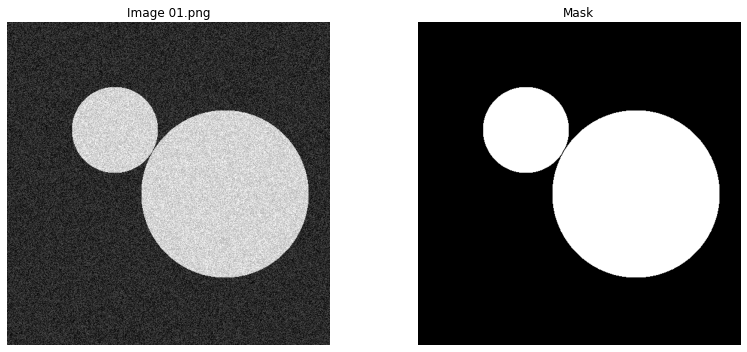

In [ ]:
path = Path('sample_data')
files = get_image_files(path/'images')
label_fn = label_fn = lambda o: path/'labels'/f'{o.stem}_mask.png'#lambda o: path/'labels'/f'{o.stem}_mask{o.suffix}'
tst = BaseDataset(files, label_fn=label_fn, fbr=0.6)
tst.show_data()

In [ ]:
tst.clear_cached_weights()

Deleting all cache at sample_data/labels/.cache


### RandomTileDataset

For training

In [ ]:
#export
class RandomTileDataset(BaseDataset):
    """
    Pytorch Dataset that creates random tiles with augmentations from the input images.
    """
    n_inp = 1
    def __init__(self, *args, sample_mult=None, flip=True, rotation_range_deg=(0, 360), deformation_grid=(150, 150), deformation_magnitude=(10, 10),
                 value_minimum_range=(0, 0), value_maximum_range=(1, 1), value_slope_range=(1, 1), p_zoom=0.75, zoom_sigma=0.1, **kwargs): 
        super().__init__(*args, **kwargs) 
        store_attr('sample_mult, flip, rotation_range_deg, deformation_grid, deformation_magnitude, value_minimum_range, \
                    value_maximum_range, value_slope_range, zoom_sigma, p_zoom')

        # Sample mulutiplier: Number of random samplings from augmented image
        if self.sample_mult is None:
            tile_shape = np.array(self.tile_shape)-np.array(self.padding)
            msk_shape = np.array(self.get_data(max_n=1)[0].shape[:-1])
            #msk_shape = np.array(lbl.shape[-2:])
            self.sample_mult = int(np.product(np.floor(msk_shape/tile_shape)))

        self.on_epoch_end()

    def __len__(self):
        return len(self.files)*self.sample_mult

    def __getitem__(self, idx):
        idx = idx % len(self.files)
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.files[idx]
        img = self.read_img(img_path, divide=self.divide)
        n_channels = img.shape[-1]       

        lbl, pdf  = self.labels[img_path.name], self.pdfs[self._name_fn(img_path.name)] 
        center = random_center(pdf[:], lbl.shape)
        X = self.gammaFcn(self.deformationField.apply(img, center).flatten()).reshape((n_channels, *self.tile_shape)).astype('float32')
        Y = self.deformationField.apply(lbl, center, self.padding, 0).astype('int64')
        if self.loss_weights: 
            _, W = cv2.connectedComponents((Y > 0).astype('uint8'), connectivity=4)
            return  TensorImage(X), TensorMask(Y), torch.Tensor(W)
        else:
            return  TensorImage(X), TensorMask(Y)

    def on_epoch_end(self, verbose=False):

        if verbose: print("Generating deformation field")
        if np.random.random()<self.p_zoom: scale=self.scale*np.random.normal(1, self.zoom_sigma)
        else: scale=self.scale
        self.deformationField = DeformationField(self.tile_shape, self.scale)

        if self.rotation_range_deg[1] > self.rotation_range_deg[0]:
            self.deformationField.rotate(
                theta=np.pi * (np.random.random()
                            * (self.rotation_range_deg[1] - self.rotation_range_deg[0])
                            + self.rotation_range_deg[0])
                            / 180.0)

        if self.flip:
            self.deformationField.mirror(np.random.choice((True,False),2))

        if self.deformation_grid is not None:
            self.deformationField.addRandomDeformation(
                self.deformation_grid, self.deformation_magnitude)

        if verbose: print("Generating value augmentation function")
        minValue = (self.value_minimum_range[0]
            + (self.value_minimum_range[1] - self.value_minimum_range[0])
            * np.random.random())

        maxValue = (self.value_maximum_range[0]
            + (self.value_maximum_range[1] - self.value_maximum_range[0])
            * np.random.random())

        intermediateValue = 0.5 * (
            self.value_slope_range[0]
            + (self.value_slope_range[1] - self.value_slope_range[0])
            * np.random.random())

        self.gammaFcn = interp1d([0, 0.5, 1.0], [minValue, intermediateValue, maxValue], kind="quadratic")

    
Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            tile_shape - The tile shape the network expects as input
            padding - The padding (input shape - output shape)
            classlabels - A list containing the corresponding class labels.
                          0 = ignore, 1 = background, 2-n foreground classes
                          If None, the problem will be treated as binary segmentation
            n_classes - The number of classes including background
            ignore - A list containing the corresponding ignore regions.
            weights - A list containing the corresponding weights.
            element_size_um - The target pixel size in micrometers
            batch_size - The number of tiles to generate per batch
            rotation_range_deg - (alpha_min, alpha_max): The range of rotation angles.
                                 A random rotation is drawn from a uniform distribution
                                 in the given range
            flip - If true, a coin flip decides whether a mirrored tile will be
                   generated
            deformation_grid - (dx, dy): The distance of neighboring grid points in
                               pixels for which random deformation vectors are drawn
            deformation_magnitude - (sx, sy): The standard deviations of the
                                    Gaussians, the components of the deformation
                                    vector are drawn from
            value_minimum_range - (v_min, v_max): Input intensity zero will be mapped
                                  to a random value in the given range
            value_maximum_range - (v_min, v_max): Input intensity one will be mapped
                                  to a random value within the given range
            value_slope_range - (s_min, s_max): The slope at control points is drawn
                                from a uniform distribution in the given range

Show data

Preprocessing ['01.png']


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.0s finished


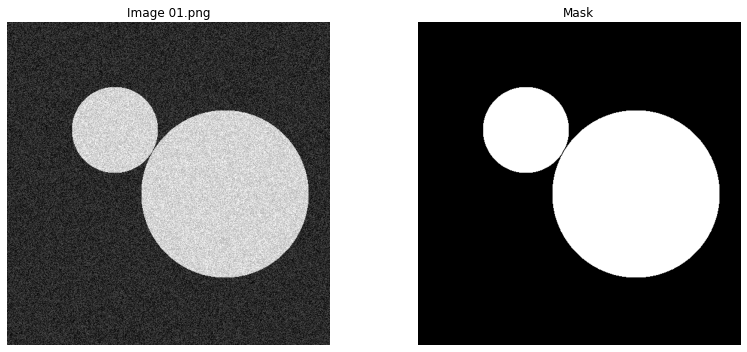

In [ ]:
tst = RandomTileDataset(files, label_fn=label_fn, n_jobs=2, verbose=2, scale=2)
tst.show_data()

Show random tile (default padding = (184,184))

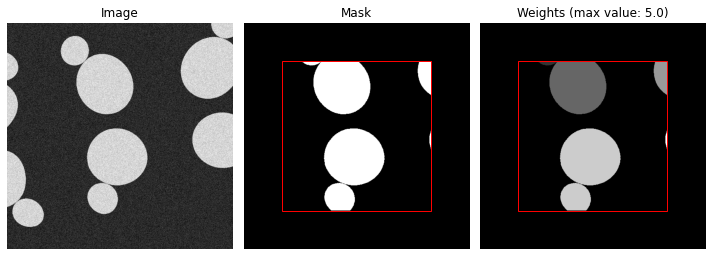

In [ ]:
tile = tst[0]
show(tile[0], tile[1], tile[2])

Compute stats

In [ ]:
tst.compute_stats()

Computing Stats...


([array([0.34416827])], [array([0.31035376])])

### TileDataset

In [ ]:
#export
class TileDataset(BaseDataset):
    "Pytorch Dataset that creates random tiles for validation and prediction on new data."
    n_inp = 1
    def __init__(self, *args, val_length=None, val_seed=42, is_zarr=False, **kwargs):
        super().__init__(*args, **kwargs)     
        self.output_shape = tuple(int(t - p) for (t, p) in zip(self.tile_shape, self.padding))
        self.tiler = DeformationField(self.tile_shape, scale=self.scale)
        self.image_indices = []
        self.image_shapes = []
        self.in_slices = []
        self.out_slices = []
        self.centers = []
        self.valid_indices = None
        
        if self.files[0].suffix == '.zarr' or is_zarr:
            self.data = zarr.open(self.files[0].parent.as_posix(), mode='r')
            is_zarr = True
        else:
            root = zarr.group(store=zarr.storage.TempStore(), overwrite=True)
            self.data = root.create_group('data')
        
        j = 0
        for i, file in enumerate(progress_bar(self.files, leave=False)):
            img = self.read_img(file, divide=self.divide)
            if not is_zarr: self.data[file.name] = img
            # Tiling
            data_shape = tuple(int(x//self.scale) for x in img.shape[:-1])
            for ty in range(max(1, int(np.ceil(data_shape[0] / self.output_shape[0])))):
                for tx in range(max(1, int(np.ceil(data_shape[1] / self.output_shape[1])))):
                    self.centers.append((int((ty + 0.5) * self.output_shape[0]*self.scale),
                                        int((tx + 0.5) * self.output_shape[1]*self.scale)))
                    self.image_indices.append(i)
                    self.image_shapes.append(data_shape)
                    sliceDef = tuple(slice(int(tIdx * o), int(min((tIdx + 1) * o, s))) for (tIdx, o, s) in zip((ty, tx), self.output_shape, data_shape))
                    self.out_slices.append(sliceDef)
                    sliceDef = tuple(slice(0, int(min((tIdx + 1) * o, s) - tIdx * o)) for (tIdx, o, s) in zip((ty, tx), self.output_shape, data_shape))
                    self.in_slices.append(sliceDef)
                    j += 1
                    
        if val_length:
            np.random.seed(val_seed)
            choice = np.random.choice(len(self.image_indices), val_length, replace=False)
            self.valid_indices = {i:idx for i, idx in  enumerate(choice)}
                        
    def __len__(self):
        if self.valid_indices: return len(self.valid_indices)
        else: return len(self.image_shapes)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.valid_indices: idx = self.valid_indices[idx]
        img_path = self.files[self.image_indices[idx]]
        img = self.data[img_path.name]
        centerPos = self.centers[idx]
        X = self.tiler.apply(img, centerPos)
        X = X.astype('float32')
        if self.label_fn is not None:
            lbl = self.labels[img_path.name]
            Y = self.tiler.apply(lbl, centerPos, self.padding, order=0).astype('int64')
            if self.loss_weights: 
                _, W = cv2.connectedComponents((Y > 0).astype('uint8'), connectivity=4)
                return  TensorImage(X), TensorMask(Y), torch.Tensor(W)
            else:
                return  TensorImage(X), TensorMask(Y)
        else:
            return TensorImage(X)

    def reconstruct_from_tiles(self, tiles):
        "Reconstruct masks or predictions from list of tiles"

        assert isinstance(tiles, list), "You need to pass a list"
        assert len(tiles) == len(self), f"Tile list must have length{len(self)}"

        out_ll = []
        for idx in range(len(self)):
            outIdx = self.image_indices[idx]
            outShape = self.image_shapes[idx]
            outSlice = self.out_slices[idx]
            inSlice = self.in_slices[idx]
            if len(out_ll) < outIdx + 1:
                if len(tiles[0].shape)>2:
                    out_ll.append(np.empty((*outShape, self.c)))
                else:
                    out_ll.append(np.empty(outShape))
            out_ll[outIdx][outSlice] = tiles[idx][inSlice]

        return out_ll

Show data

Using preprocessed masks from sample_data/labels/.cache


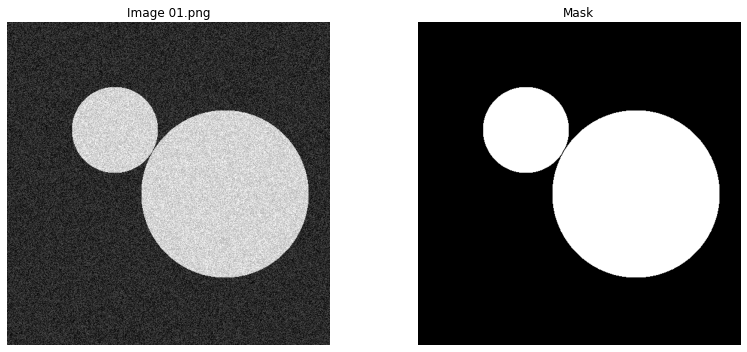

In [ ]:
tst = TileDataset(files, label_fn=label_fn, tile_shape=(450,450), padding=(10,10), val_length=2)
tst.show_data()

Show tiles

Tile 0


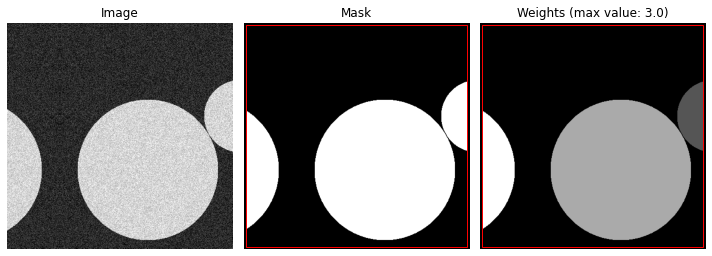

Tile 1


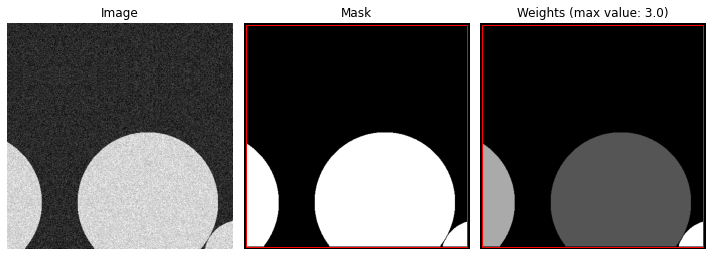

In [ ]:
for i in range(len(tst)): 
    print(f'Tile {i}')
    tile = tst[i]
    show(tile[0], tile[1], tile[2])

Reconstruct masks

Using preprocessed masks from sample_data/labels/.cache


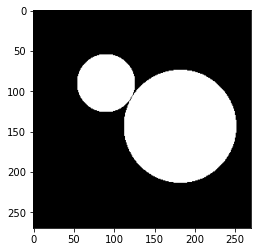

In [ ]:
tst = TileDataset(files, label_fn=label_fn, tile_shape=(440,440), padding=(10,10), scale=2)
msk_tiles = [x[1] for x in tst]
msk = tst.reconstruct_from_tiles(msk_tiles)
plt.imshow(msk[0], cmap='binary_r');

## Export -

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_learner.ipynb.
Converted 01_models.ipynb.
Converted 02_data.ipynb.
Converted 02a_transforms.ipynb.
Converted 03_metrics.ipynb.
Converted 04_callbacks.ipynb.
Converted 05_losses.ipynb.
Converted 06_utils.ipynb.
Converted 07_tta.ipynb.
Converted 08_gui.ipynb.
Converted 09_gt.ipynb.
Converted add_information.ipynb.
Converted deepflash2.ipynb.
Converted gt_estimation.ipynb.
Converted index.ipynb.
Converted model_library.ipynb.
Converted predict.ipynb.
Converted train.ipynb.
Converted tutorial.ipynb.
